In [ ]:
!pip install opencv-python tqdm
import cv2
import os
import glob
import numpy as np
from tqdm import tqdm  # For progress tracking

In [ ]:
# Paths to videos
REAL_VIDEOS_PATH = "/content/drive/MyDrive/Dataset/Real"
FAKE_VIDEOS_PATH = "/content/drive/MyDrive/Dataset/Fake"

# Paths to save extracted frames
OUTPUT_REAL_FRAMES = "/content/frames/real"
OUTPUT_FAKE_FRAMES = "/content/frames/fake"

# Create directories if not exist
os.makedirs(OUTPUT_REAL_FRAMES, exist_ok=True)
os.makedirs(OUTPUT_FAKE_FRAMES, exist_ok=True)


In [ ]:
def extract_frames(video_path, output_folder, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_interval == 0:  # Extract every nth frame
            frame_name = f"{os.path.basename(video_path).split('.')[0]}_frame{frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)

        success, frame = cap.read()
        frame_count += 1

    cap.release()

In [ ]:
# Extract frames from REAL videos
for video_file in tqdm(glob.glob(os.path.join(REAL_VIDEOS_PATH, "*.mov"))):
    extract_frames(video_file, OUTPUT_REAL_FRAMES)

# Extract frames from FAKE videos
for video_file in tqdm(glob.glob(os.path.join(FAKE_VIDEOS_PATH, "*.avi"))):
    extract_frames(video_file, OUTPUT_FAKE_FRAMES)

print("Frame extraction completed!")

100%|██████████| 320/320 [00:21<00:00, 15.02it/s]

Frame extraction completed!


In [ ]:
print(f"Total Real Frames: {len(os.listdir(OUTPUT_REAL_FRAMES))}")
print(f"Total Fake Frames: {len(os.listdir(OUTPUT_FAKE_FRAMES))}")

Total Real Frames: 48
Total Fake Frames: 6933


In [ ]:
!pip install tensorflow-cpu

In [ ]:
!pip install keras numpy matplotlib opencv-python scikit-learn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SIZE = 224  # Resize images to 128x128 (change to 224x224 for deeper networks)
REAL_FRAMES_PATH = "/content/frames/real"
FAKE_FRAMES_PATH = "/content/frames/fake"

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            img = img / 255.0  # Normalize (0-1)
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load Real and Fake images
real_images, real_labels = load_images_from_folder(REAL_FRAMES_PATH, label=0)  # 0 for Real
fake_images, fake_labels = load_images_from_folder(FAKE_FRAMES_PATH, label=1)  # 1 for Fake

# Combine and Shuffle Dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

# Shuffle data
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")


Training Data: (5584, 224, 224, 3), Test Data: (1397, 224, 224, 3)


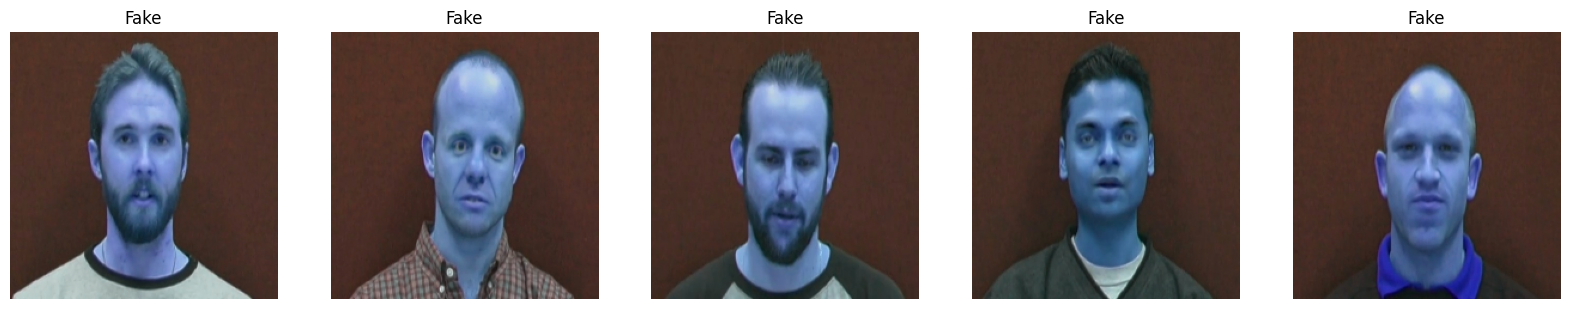

In [ ]:
plt.figure(figsize=(20,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Fake" if y_train[i] == 1 else "Real")
    plt.axis("off")
plt.show()

In [ ]:
# ipython-input-10-84c5b0e46e40

import tensorflow as tf # Changed import to tensorflow_cpu
from tensorflow.keras.models import Sequential  # Changed import to tensorflow_cpu
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Changed import to tensorflow_cpu
from tensorflow.keras.optimizers import Adam # Changed import to tensorflow_cpu

In [ ]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=16,
                    verbose=1)

Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 154s 436ms/step - accuracy: 0.9860 - loss: 0.0856 - val_accuracy: 0.9914 - val_loss: 0.0437
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 149s 427ms/step - accuracy: 0.9933 - loss: 0.0359 - val_accuracy: 0.9914 - val_loss: 0.0429
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 148s 423ms/step - accuracy: 0.9916 - loss: 0.0363 - val_accuracy: 0.9914 - val_loss: 0.0258
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 142s 407ms/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 0.9914 - val_loss: 0.0295
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 400ms/step - accuracy: 0.9933 - loss: 0.0164 - val_accuracy: 0.9914 - val_loss: 0.0212
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 138s 394ms/step - accuracy: 0.9943 - loss: 0.0140 - val_accuracy: 0.9914 - val_loss: 0.0227
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 139s 397ms/step - accuracy: 0.9937 - loss: 0.0139 - val_accuracy: 0.9914 - val_loss: 0.0178
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 138s 396ms/step - accuracy: 0.9935 -

In [ ]:
# Save model
# model.save("deepfake_detector.h5")

# Load model
from tensorflow.keras.models import load_model
model = load_model("deepfake_detector.h5")

In [22]:
model = load_model(r"C:\Users\jaiag\Desktop\Postulate\deepfake_detector.h5")

In [13]:
import cv2
import numpy as np

def extract_frames(video_path, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    success, frame = cap.read()
    while success:
        if frame_count % frame_interval == 0:
            frame = cv2.resize(frame, (128, 128))  # Resize
            frame = frame / 255.0  # Normalize
            frames.append(frame)

        success, frame = cap.read()
        frame_count += 1

    cap.release()
    return np.array(frames)

In [27]:
cap = cv2.VideoCapture(r"C:\Users\jaiag\Desktop\Postulate\DeepfakeTIMIT\DeepfakeTIMIT\higher_quality\fadg0\si1279-video-fram1.avi")
frames = []
frame_interval = 5
frame_count = 0

success, frame = cap.read()
while success:
    if frame_count % frame_interval == 0:
        frame = cv2.resize(frame, (128, 128))  # Resize
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    success, frame = cap.read()
    frame_count += 1

cap.release()
frames = np.array(frames)
predictions = model.predict(frames)  # Get predictions for each frame

avg_prediction = np.mean(predictions)  # Average across all frames
print(f"Average Prediction Score: {avg_prediction:.4f}")

# If avg_prediction > 0.5, classify as Fake; else, Real
video_label = "Fake" if avg_prediction > 0.5 else "Real"
print(f"Final Video Classification: {video_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Average Prediction Score: 0.0000
Final Video Classification: Real


In [28]:
type (frames)

numpy.ndarray

In [14]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    predictions = model.predict(frames)  # Get predictions for each frame

    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")

    # If avg_prediction > 0.5, classify as Fake; else, Real
    video_label = "Fake" if avg_prediction > 0.5 else "Real"
    print(f"Final Video Classification: {video_label}")

In [21]:
# Test on a sample video
test_video_path = r"C:\Users\jaiag\Desktop\Postulate\DeepfakeTIMIT\DeepfakeTIMIT\higher_quality\fadg0\sa2-video-fram1.avi"
predict_video(test_video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Average Prediction Score: 0.0000
Final Video Classification: Real


In [ ]:
# Test on a sample video
test_video_path = "/content/WIN_20250208_13_28_26_Pro.mp4"
predict_video(test_video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Average Prediction Score: 1.0000
Final Video Classification: Fake
